In [2]:
!pip install -q transformers

In [58]:
# Imports for this notebook

import os
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt


from transformers import YolosImageProcessor
from transformers import YolosForObjectDetection
from torch import nn

(640, 480)


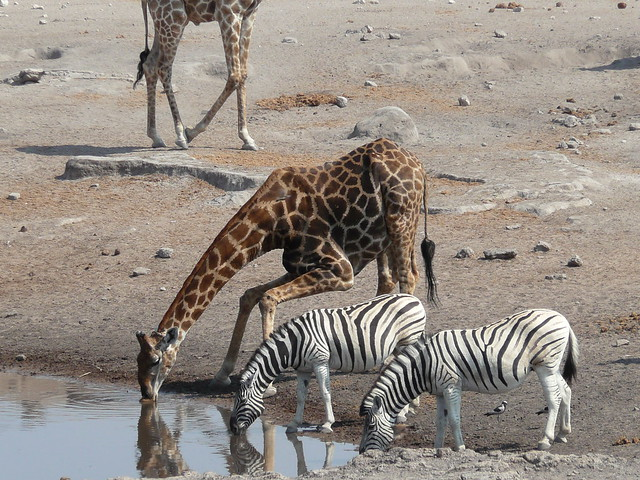

In [40]:
from PIL import Image
import requests

url = 'https://farm4.staticflickr.com/3212/2337987673_be9cb487cb_z.jpg'
image = Image.open(requests.get(url, stream=True).raw)
print(image.size)
image

In [17]:
model_name = "hustvl/yolos-small"

In [41]:
# Instantiate the image processor. By default, it normalized the image using
# ImageNet mean and std and resizes them to shape (800, 1056). You can modify
# by setting the `size` parameter.
image_processor = YolosImageProcessor.from_pretrained(model_name)

In [42]:
# Run a PIL image through the Image Processor. The output shape is
# batch size x num_channels x height x width.
pixel_values = image_processor.preprocess(image, return_tensors="pt").pixel_values
pixel_values.shape

torch.Size([1, 3, 800, 1056])

In [43]:
# Load the model
model = YolosForObjectDetection.from_pretrained(model_name)

In [44]:
# Get model predictions on the processed image.
with torch.no_grad():
    outputs = model(pixel_values, output_attentions=True)

In [45]:
outputs.keys()

odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'attentions'])

In [46]:
# YOLOS consists of N patch tokens as inputs and 100 detection tokens
# in the output. Since the label space consists of 92 classes, we have
# a logits vector per detection token. The number of patches are controlled
# by the input image size and the model patch size parameter, defaults to 16 pixels.
outputs.logits.shape

torch.Size([1, 100, 92])

In [47]:
# Similarly, we have one bounding box corresponding to the class with the
# highest detection probability per detection token. The bounding box uses
# the (xcen, ycen, width, height) convention and are in dimensionless units
# with the top-left as (0, 0) and bottom-right as (1, 1).
outputs.pred_boxes.shape

torch.Size([1, 100, 4])

In [48]:
# Since the YOLOS consists of 12 MultiHead attention blocks, the `attentions`
# is a list of 12 multihead attentions.
print("# of MultiHead attention blocks:", len(outputs.attentions))

# Each block consists of 6 heads, while each head is of shape ((N+100) x (N+100)),
# indicating the `attention` given by a token `i` to token `j`.
# Here N are the number of patch tokens, while the number
# of detection tokens are 100. By default there are 3300 patch tokens.
print("Shape of single multihead attention: ", outputs.attentions[0].shape)

# of MultiHead attention blocks: 12
Shape of single multihead attention:  torch.Size([1, 6, 3401, 3401])


In [49]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_image, prob, boxes):
    fig, ax = plt.subplots()
    ax.imshow(pil_image)

    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle(xy=(xmin, ymin),
                                   height=(ymax - ymin),
                                   width=(xmax - xmin),
                                   fill=False, color=c))

        # Get the class label corresponding to this bounding box
        class_idx = p.argmax()
        class_label = f'{model.config.id2label[class_idx.item()]}: {p[class_idx]:0.2f}'
        ax.text(xmin, ymin, class_label, bbox=dict(facecolor="yellow", alpha=0.6))
    plt.axis('off')
    plt.show()

In [50]:
# Convert logits to probabilities and keep detections with strong signal.
probas = outputs.logits.softmax(dim=-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# rescale bounding boxes to the original image
target_sizes = torch.tensor(image.size[::-1]).unsqueeze(0)

# We need the target sizes to be (height, width) that's why we flipped the
# axes in the above line: `image.size[::-1]`
postprocessed_outputs = image_processor.post_process(outputs,
                                                     target_sizes=target_sizes)
# feature_extractor.post_process_object_detection()
bboxes_scaled = postprocessed_outputs[0]['boxes']

`post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection` instead, with `threshold=0.` for equivalent results.


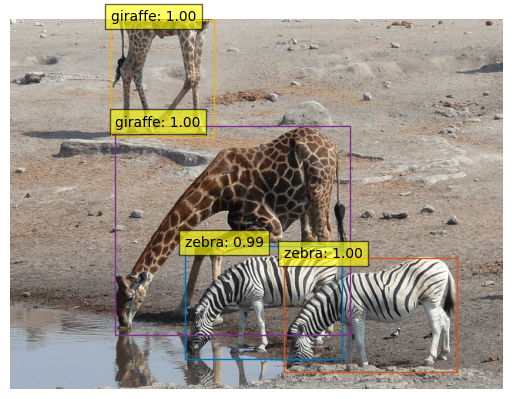

In [51]:
plot_results(image, probas[keep], bboxes_scaled[keep])

In [52]:
# Let's look at the attentions of the last layer
attention = outputs.attentions[-1].detach().cpu()

# Shape of attentions: batch_size x num_heads x # tokens x # tokens
nh = attention.shape[1]
print(nh)

6


In [53]:
# Here we consider the attention of the detection tokens to the
# patch tokens.
attention = attention[0, :, -model.config.num_detection_tokens:,
                      1:-model.config.num_detection_tokens]

In [55]:
# These are the detection tokens with detection prob > 90%
vis_idxs = torch.nonzero(keep).squeeze(1)
print(vis_idxs)

tensor([13, 30, 43, 68])


In [56]:
output_dir = "./visualization"

In [59]:
h, w = pixel_values.shape[2:]  # Output after preprocessing
w_featmap = w // model.config.patch_size
h_featmap = h // model.config.patch_size

def get_one_query_meanattn(attention, h_featmap, w_featmap):
    # Take mean across all the heads
    mean_attentions = attention.mean(0).reshape(h_featmap, w_featmap)
    mean_attentions = nn.functional.interpolate(mean_attentions.unsqueeze(0).unsqueeze(0),
                                                scale_factor=16, mode="nearest")[0].cpu().numpy()
    return mean_attentions

def get_one_query_attn(attention, h_featmap, w_featmap, nh):
    map_attention = attention.reshape(nh, h_featmap, w_featmap)
    map_attention = nn.functional.interpolate(map_attention.unsqueeze(0),
                                              scale_factor=16, mode="nearest")[0].cpu().numpy()
    return map_attention

def box_cxcywh_xyxy(box):
    # Given a box in (center, width, height) representation, convert it
    # to (topleft, bottomright) representation
    cx, cy, w, h = box.unbind(1)
    b = [
        (cx - 0.5 * w), (cy - 0.5 * h),
        (cx + 0.5 * w), (cy + 0.5 * h)
    ]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def draw_bbox_in_img(fname, bbox, score, color):
    tl = 3
    tf = max(tl - 1, 1)

    im = cv2.imread(fname)
    for p, (xmin, ymin, xmax, ymax) in zip(score, bbox.tolist()):
        c1, c2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        cv2.rectangle(im, c1, c2, color, tl, lineType=cv2.LINE_AA)

        class_idx = p.argmax()
        class_label = f'{model.config.id2label[class_idx.item()]}: {p[class_idx]:0.2f}'

        # # Bottom right point of the class label name rectangle
        # t_size = cv2.getTextSize(class_label, 0, fontScale=tl / 3, thickness=tf)[0]
        # c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        # cv2.rectangle(im, c1, c2, color, -1, lineType=cv2.LINE_AA)

        # # Add the class label
        # cv2.putText(im, class_label, (c1[0], c1[1] - 2), 0, tl / 3,
        #             [255, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    cv2.imwrite(fname, im)

for idx, vis_idx in enumerate(vis_idxs):
    token_dir = os.path.join(output_dir, 'Det-Tok-'+str(int(vis_idx)))
    os.makedirs(token_dir, exist_ok=True)

    bbox = rescale_bboxes(outputs.pred_boxes[0, vis_idx].unsqueeze(0).cpu(), (w, h))
    score = probas[vis_idx].unsqueeze(0)

    # Focus on the attention for this particular token
    this_attention = attention[:, vis_idx, :]  # shape: 6 x 3300

    # Get mean across all heads
    mean_attention = get_one_query_meanattn(this_attention, h_featmap, w_featmap)
    mean_attention = mean_attention[0]

    fname = os.path.join(token_dir, "attn-head-mean.png")
    plt.imsave(fname=fname, arr=mean_attention, format='png')
    print(f"{fname} saved.")

    attn = get_one_query_attn(this_attention, h_featmap, w_featmap, nh)
    for i in range(nh):
        fname = os.path.join(token_dir, "attn-head" + str(i) + ".png")
        plt.imsave(fname=fname, arr=attn[i], format='png')
        draw_bbox_in_img(fname, bbox, score, color=[0, 0, 255])
        print(f"{fname} saved.")


./visualization/Det-Tok-13/attn-head-mean.png saved.
./visualization/Det-Tok-13/attn-head0.png saved.
./visualization/Det-Tok-13/attn-head1.png saved.
./visualization/Det-Tok-13/attn-head2.png saved.
./visualization/Det-Tok-13/attn-head3.png saved.
./visualization/Det-Tok-13/attn-head4.png saved.
./visualization/Det-Tok-13/attn-head5.png saved.
./visualization/Det-Tok-30/attn-head-mean.png saved.
./visualization/Det-Tok-30/attn-head0.png saved.
./visualization/Det-Tok-30/attn-head1.png saved.
./visualization/Det-Tok-30/attn-head2.png saved.
./visualization/Det-Tok-30/attn-head3.png saved.
./visualization/Det-Tok-30/attn-head4.png saved.
./visualization/Det-Tok-30/attn-head5.png saved.
./visualization/Det-Tok-43/attn-head-mean.png saved.
./visualization/Det-Tok-43/attn-head0.png saved.
./visualization/Det-Tok-43/attn-head1.png saved.
./visualization/Det-Tok-43/attn-head2.png saved.
./visualization/Det-Tok-43/attn-head3.png saved.
./visualization/Det-Tok-43/attn-head4.png saved.
./visual

In [60]:
path = os.listdir(output_dir)
det_tok_dirs = []
for p in path:
    temp_path=os.path.join(output_dir, p)
    if os.path.isdir(temp_path):
        det_tok_dirs.append(temp_path)
sorted(det_tok_dirs)

['./visualization/Det-Tok-13',
 './visualization/Det-Tok-30',
 './visualization/Det-Tok-43',
 './visualization/Det-Tok-68']

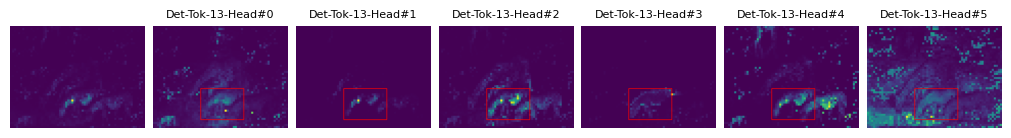

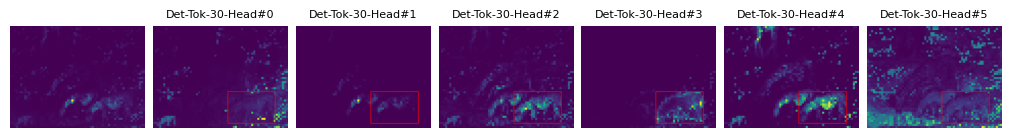

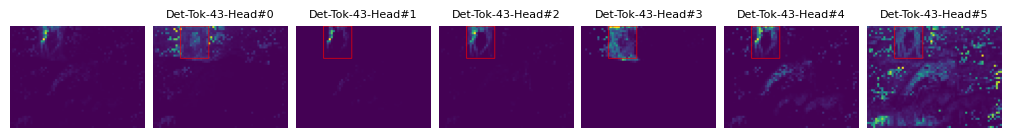

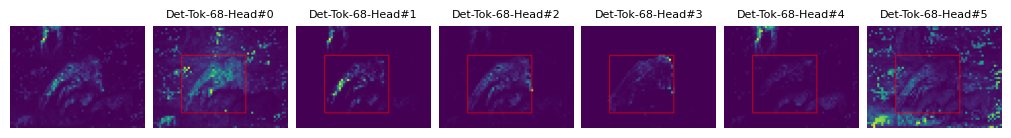

In [61]:
for det_tok_dir in sorted(det_tok_dirs):
    fig = plt.figure(constrained_layout=True, figsize=(10, 5))
    gs = fig.add_gridspec(1, nh+1)

    head_axs = [
        fig.add_subplot(gs[0, 1]),
        fig.add_subplot(gs[0, 2]),
        fig.add_subplot(gs[0, 3]),
        fig.add_subplot(gs[0, 4]),
        fig.add_subplot(gs[0, 5]),
        fig.add_subplot(gs[0, 6]),
    ]

    det_tok_names = ['attn-head0.png', 'attn-head1.png', 'attn-head2.png',
                     'attn-head3.png', 'attn-head4.png', 'attn-head5.png']

    # Read in image file paths for all the heads
    det_tok_dir_files = []
    for det_tok_name in det_tok_names:
        det_tok_dir_files.append(os.path.join(det_tok_dir, det_tok_name))

    head_index = 0
    for det_tok_dir_file, head_ax in zip(det_tok_dir_files, head_axs):
        im = plt.imread(det_tok_dir_file)
        head_ax.imshow(im)

        head_ax.set_title('%s-Head#%d' %(det_tok_dir.split('/')[-1], head_index), fontsize=8)
        head_ax.axis('off')

        head_index += 1

    # Add the mean attention subplot
    mean_ax = fig.add_subplot(gs[0, 0])
    im = plt.imread(os.path.join(det_tok_dir, 'attn-head-mean.png'))
    mean_ax.imshow(im)
    mean_ax.axis('off')

    plt.show()